## 1. Load model


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import DataLoader

# Define the model class (copy from your training script)
class ParticleDynamicsGNN(MessagePassing):
    """Graph Neural Network for predicting particle dynamics in SPH simulations"""
    
    def __init__(self, in_channels, hidden_channels=64, num_layers=3, dropout=0.1):
        super().__init__(aggr='add')
        
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Input embedding
        self.input_embedding = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Message passing layers
        self.message_mlps = nn.ModuleList()
        self.update_mlps = nn.ModuleList()
        
        for _ in range(num_layers):
            # Message MLP
            message_mlp = nn.Sequential(
                nn.Linear(2 * hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_channels, hidden_channels)
            )
            self.message_mlps.append(message_mlp)
            
            # Update MLP
            update_mlp = nn.Sequential(
                nn.Linear(2 * hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_channels, hidden_channels)
            )
            self.update_mlps.append(update_mlp)
        
        # Output layer for position prediction
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, 2)  # Predict 2D position
        )
        
        # Skip connections
        self.skip_connections = nn.ModuleList([
            nn.Linear(hidden_channels, hidden_channels) for _ in range(num_layers)
        ])
        
    def forward(self, x, edge_index, batch=None):
        # Input embedding
        h = self.input_embedding(x)
        
        # Store for skip connections
        residual = h
        
        # Message passing layers
        for i in range(self.num_layers):
            h_new = self.propagate(edge_index, x=h, layer_idx=i)
            
            # Skip connection
            if i > 0:
                h_new = h_new + self.skip_connections[i](residual)
            
            h = h_new
            
            # Update residual every 2 layers
            if i % 2 == 1:
                residual = h
        
        # Output layer
        out = self.output_layer(h)
        
        return out
    
    def message(self, x_i, x_j, layer_idx):
        msg_input = torch.cat([x_i, x_j], dim=1)
        msg = self.message_mlps[layer_idx](msg_input)
        return msg
    
    def update(self, aggr_out, x, layer_idx):
        update_input = torch.cat([x, aggr_out], dim=1)
        updated = self.update_mlps[layer_idx](update_input)
        return updated
    
    def propagate(self, edge_index, x, layer_idx):
        row, col = edge_index
        x_i = x[row]
        x_j = x[col]
        
        msg = self.message(x_i, x_j, layer_idx)
        
        aggr_out = torch.zeros_like(x)
        aggr_out.index_add_(0, row, msg)
        
        out = self.update(aggr_out, x, layer_idx)
        return out

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu');
print(f"Device in use: {device}")

# Load the checkpoint
checkpoint = torch.load('./complete_gnn_physics_model_1.pth', map_location=device)

# Get model config and create model instance
model_config = checkpoint['model_config']
model = ParticleDynamicsGNN(**model_config)

# Load the state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"Model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model config: {model_config}")

Device in use: mps
Model loaded successfully!
Model parameters: 470,466
Model config: {'in_channels': 5, 'hidden_channels': 128, 'num_layers': 4, 'dropout': 0.15}


## 2. Measure inference time

In [3]:
def build_neighbor_graph(positions, radius=0.01, max_neighbors=10):
    """Build graph connectivity from particle positions using spatial partitioning"""
    n_particles = positions.size(0)
    
    # Step 1: Set up spatial grid
    # Determine grid cell size based on interaction radius
    cell_size = radius
    
    # Find bounds of the space
    min_x, min_y = positions[:, 0].min().item(), positions[:, 1].min().item()
    max_x, max_y = positions[:, 0].max().item(), positions[:, 1].max().item()
    
    # Add small padding to avoid edge issues
    padding = cell_size * 0.01
    min_x -= padding
    min_y -= padding
    max_x += padding
    max_y += padding
    
    # Calculate grid dimensions
    grid_width = int((max_x - min_x) / cell_size) + 1
    grid_height = int((max_y - min_y) / cell_size) + 1
    
    # Step 2: Assign particles to grid cells
    # Calculate cell indices for each particle
    cell_x = ((positions[:, 0] - min_x) / cell_size).long()
    cell_y = ((positions[:, 1] - min_y) / cell_size).long()
    cell_indices = cell_y * grid_width + cell_x
    
    # Create a dictionary mapping cell indices to particle indices
    grid_cells = {}
    for particle_idx, cell_idx in enumerate(cell_indices):
        cell_idx = cell_idx.item()  # Convert tensor to value
        if cell_idx not in grid_cells:
            grid_cells[cell_idx] = []
        grid_cells[cell_idx].append(particle_idx)
    
    # Step 3: Find neighbors efficiently
    edge_list = []
    
    for i in range(n_particles):
        # Get the cell of this particle
        cell_idx_i = cell_indices[i].item()
        cell_x_i = cell_idx_i % grid_width
        cell_y_i = cell_idx_i // grid_width
        
        # Collect neighbors
        neighbors = []
        
        # Check the 9 neighboring cells (3x3 grid centered on particle's cell)
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                neighbor_x = cell_x_i + dx
                neighbor_y = cell_y_i + dy
                
                # Skip cells that are outside the grid
                if (neighbor_x < 0 or neighbor_x >= grid_width or
                    neighbor_y < 0 or neighbor_y >= grid_height):
                    continue
                
                neighbor_cell_idx = neighbor_y * grid_width + neighbor_x
                
                # Get particles in this neighboring cell
                neighbor_particles = grid_cells.get(neighbor_cell_idx, [])
                
                for j in neighbor_particles:
                    # Skip self connections
                    if i == j:
                        continue
                    
                    # Calculate actual distance
                    dist = torch.norm(positions[i] - positions[j]).item()
                    
                    # Check if within radius
                    if dist <= radius:
                        neighbors.append((j, dist))
        
        # Limit number of neighbors if needed
        if max_neighbors is not None and len(neighbors) > max_neighbors:
            neighbors.sort(key=lambda x: x[1])  # Sort by distance
            neighbors = neighbors[:max_neighbors]
        
        # Add edges
        for j, _ in neighbors:
            edge_list.append([i, j])
    
    # Convert edge list to tensor
    if edge_list:  # Check if we found any edges
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    else:
        # Return empty edge index
        edge_index = torch.zeros((2, 0), dtype=torch.long)
    
    return edge_index

In [4]:
# Create test data from your training pipeline
# First, let's load the same data preparation functions
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import h5py
import os


def create_graph_data(positions, particle_types, timestep_idx, target_positions=None):
    """Create PyTorch Geometric Data object from particle data"""
    # Node features: [x, y, particle_type_one_hot, timestep_normalized]
    num_types = particle_types.max().item() + 1
    type_one_hot = F.one_hot(particle_types, num_classes=num_types).float()
    
    # Normalize timestep
    timestep_feature = torch.full((len(positions), 1), timestep_idx / 100.0)
    
    # Combine features
    x = torch.cat([positions, type_one_hot, timestep_feature], dim=1)
    
    # Build graph connectivity
    edge_index = build_neighbor_graph(positions, radius=0.1)
    
    # Create data object
    data = Data(x=x, edge_index=edge_index)
    
    if target_positions is not None:
        data.y = target_positions
    
    return data

def load_h5_dataset(filepath, max_episodes=None, skip_timesteps=1):
    """Load SPH dataset from H5 file with memory optimization"""
    with h5py.File(filepath, 'r') as f:
        episodes = sorted(list(f.keys()))
        if max_episodes:
            episodes = episodes[:max_episodes]
        
        print(f"Loading {len(episodes)} episodes from {os.path.basename(filepath)}")
        
        all_positions = []
        all_particle_types = []
        
        for i, episode_id in enumerate(episodes):
            if i % 10 == 0:
                print(f"  Loading episode {i+1}/{len(episodes)}...")
                
            # Load position data with optional timestep skipping
            positions = f[f'{episode_id}/position'][::skip_timesteps]
            particle_types = f[f'{episode_id}/particle_type'][:]
            
            all_positions.append(torch.tensor(positions, dtype=torch.float32))
            all_particle_types.append(torch.tensor(particle_types, dtype=torch.long))
            
        # Stack all episodes
        positions = torch.stack(all_positions)
        particle_types = torch.stack(all_particle_types)
        
        print(f"Final shape - Positions: {positions.shape}, Types: {particle_types.shape}")
        return positions, particle_types

def prepare_training_data(positions, particle_types, sequence_length=5):
    """Prepare sequences of graph data for training"""
    data_list = []
    
    for episode in range(positions.shape[0]):
        episode_types = particle_types[episode]
        
        for t in range(positions.shape[1] - sequence_length):
            # Current state
            current_pos = positions[episode, t]
            
            # Target (next timestep)
            target_pos = positions[episode, t + 1]
            
            # Create graph data
            data = create_graph_data(current_pos, episode_types, t, target_pos)
            data_list.append(data)
    
    return data_list

print("="*60)
print("DATA PREPARATION PHASE")
print("="*60)

# Load test data (same as in your training pipeline)
data_dir = '/Volumes/Meida/01-CodeLab/01-personal-project/GNN/2D_DAM_5740_20kevery100'
test_path = os.path.join(data_dir, 'test.h5')

print("Loading test data...")
test_pos, test_types = load_h5_dataset(test_path, max_episodes=2, skip_timesteps=5)

print("Preparing test data...")
test_data_list = prepare_training_data(test_pos, test_types)
print(f"Created {len(test_data_list)} test samples")

# Create test loader
batch_size = 2  # Same as training
test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)

print(f"Test loader created with {len(test_loader)} batches")
print(f"Sample test data shape: {test_data_list[0].x.shape}")

print("\n" + "="*60)
print("DATA PREPARATION COMPLETE")
print("="*60)
print(f"✓ Loaded {len(test_data_list)} test samples")
print(f"✓ Created data loader with {len(test_loader)} batches")
print(f"✓ Sample graph: {test_data_list[0].x.shape[0]} nodes, {test_data_list[0].edge_index.shape[1]} edges")
print(f"✓ Node features: {test_data_list[0].x.shape[1]} dimensions")

DATA PREPARATION PHASE
Loading test data...
Loading 2 episodes from test.h5
  Loading episode 1/2...
Final shape - Positions: torch.Size([2, 81, 5740, 2]), Types: torch.Size([2, 5740])
Preparing test data...
Created 152 test samples
Test loader created with 76 batches
Sample test data shape: torch.Size([5740, 5])

DATA PREPARATION COMPLETE
✓ Loaded 152 test samples
✓ Created data loader with 76 batches
✓ Sample graph: 5740 nodes, 56874 edges
✓ Node features: 5 dimensions


/Users/mac/miniconda3/envs/sandbox-ml/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## 3. Collect data phase 

PARTICLE COUNT BENCHMARKING
Original graph: 5740 particles, 56874 edges

--- Testing with 1,000 particles ---
Subsampled graph: 1000 particles, 1734 edges
Mean inference time: 4.19 ms
Time per particle: 4.19 μs
Maximum FPS: 238.8

--- Testing with 2,000 particles ---
Subsampled graph: 2000 particles, 6931 edges
Mean inference time: 9.48 ms
Time per particle: 4.74 μs
Maximum FPS: 105.5

--- Testing with 3,000 particles ---
Subsampled graph: 3000 particles, 15583 edges
Mean inference time: 21.90 ms
Time per particle: 7.30 μs
Maximum FPS: 45.7

--- Testing with 5,000 particles ---
Subsampled graph: 5000 particles, 43081 edges
Mean inference time: 66.87 ms
Time per particle: 13.37 μs
Maximum FPS: 15.0

--- Testing with 5,740 particles ---
Subsampled graph: 5740 particles, 56874 edges
Mean inference time: 89.42 ms
Time per particle: 15.58 μs
Maximum FPS: 11.2

PARTICLE COUNT SUMMARY
 Particles |      Edges |  Time (ms) |      FPS |  Time/Node |  Time/Edge
-----------------------------------

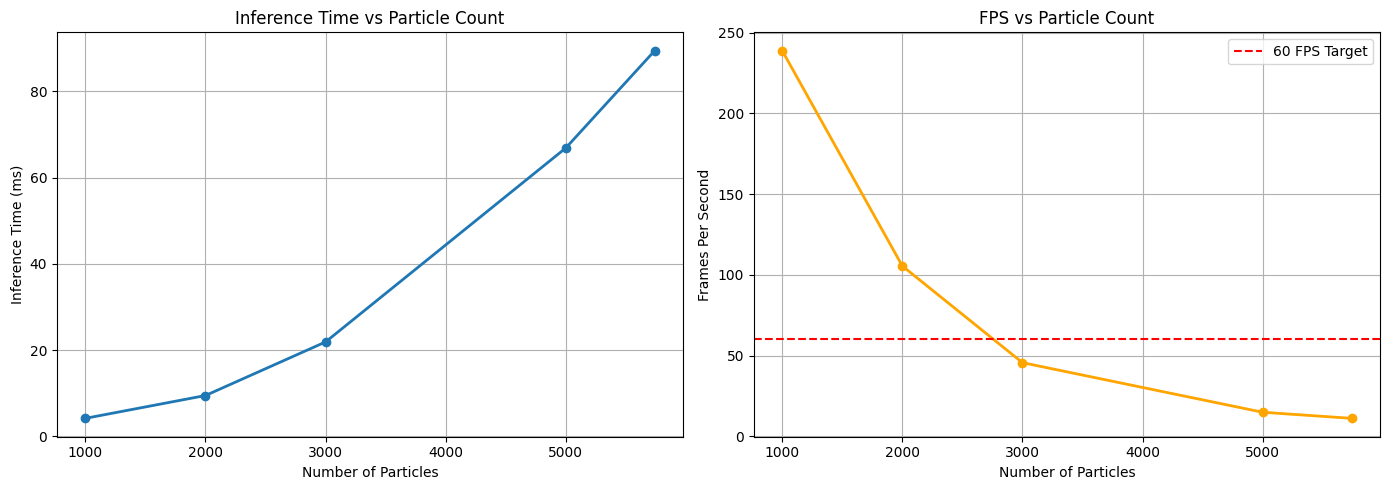

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
from torch_geometric.data import Data

def benchmark_particle_counts(model, test_data_list, device, particle_counts=[1000, 2000, 5000], num_runs=20):
    """
    Benchmark inference performance with different numbers of particles
    
    Args:
        model: Trained GNN model
        test_data_list: List of graph data samples
        device: Device to run inference on
        particle_counts: List of particle counts to test
        num_runs: Number of runs for each configuration
        
    Returns:
        Dictionary with benchmark results
    """
    print("="*60)
    print("PARTICLE COUNT BENCHMARKING")
    print("="*60)
    
    # Use the first sample graph as our baseline
    original_data = test_data_list[0].clone()
    original_num_nodes = original_data.x.shape[0]
    
    print(f"Original graph: {original_num_nodes} particles, {original_data.edge_index.shape[1]} edges")
    
    results = {}
    
    # Validate requested particle counts
    valid_counts = [c for c in particle_counts if c <= original_num_nodes]
    if len(valid_counts) < len(particle_counts):
        skipped = set(particle_counts) - set(valid_counts)
        print(f"⚠️ Skipping counts that exceed available particles: {skipped}")
    
    for count in valid_counts:
        print(f"\n--- Testing with {count:,} particles ---")
        
        # Subsample the nodes
        indices = torch.randperm(original_num_nodes)[:count]
        
        # Create a node mapping for edges
        node_mapping = -torch.ones(original_num_nodes, dtype=torch.long)
        node_mapping[indices] = torch.arange(count)
        
        # Create subsampled data
        subsampled_x = original_data.x[indices]
        
        # Filter edges where both endpoints are in the subsample
        edge_index = original_data.edge_index
        src, dst = edge_index[0], edge_index[1]
        
        edge_mask = (node_mapping[src] >= 0) & (node_mapping[dst] >= 0)
        subsampled_edges = edge_index[:, edge_mask]
        
        # Remap node indices
        subsampled_edges[0] = node_mapping[subsampled_edges[0]]
        subsampled_edges[1] = node_mapping[subsampled_edges[1]]
        
        # Create new data object
        data = Data(x=subsampled_x, edge_index=subsampled_edges)
        data = data.to(device)
        
        edge_count = data.edge_index.shape[1]
        print(f"Subsampled graph: {count} particles, {edge_count} edges")
        
        # Warmup
        with torch.no_grad():
            for _ in range(5):
                _ = model(data.x, data.edge_index)
        
        # Synchronize device
        if device.type == 'cuda':
            torch.cuda.synchronize()
        elif device.type == 'mps':
            torch.mps.synchronize()
        
        # Timed runs
        inference_times = []
        with torch.no_grad():
            for i in range(num_runs):
                start = time.perf_counter()
                
                _ = model(data.x, data.edge_index)
                
                if device.type == 'cuda':
                    torch.cuda.synchronize()
                elif device.type == 'mps':
                    torch.mps.synchronize()
                    
                inference_times.append((time.perf_counter() - start) * 1000)  # ms
        
        # Calculate metrics
        times_array = np.array(inference_times)
        
        results[count] = {
            'mean_ms': np.mean(times_array),
            'std_ms': np.std(times_array),
            'min_ms': np.min(times_array),
            'max_ms': np.max(times_array),
            'p95_ms': np.percentile(times_array, 95),
            'edge_count': edge_count,
            'time_per_node_us': (np.mean(times_array) * 1000) / count,
            'time_per_edge_us': (np.mean(times_array) * 1000) / edge_count,
            'fps': 1000 / np.mean(times_array)
        }
        
        print(f"Mean inference time: {results[count]['mean_ms']:.2f} ms")
        print(f"Time per particle: {results[count]['time_per_node_us']:.2f} μs")
        print(f"Maximum FPS: {results[count]['fps']:.1f}")
        
    # Generate summary table
    print("\n" + "="*60)
    print("PARTICLE COUNT SUMMARY")
    print("="*60)
    print(f"{'Particles':>10} | {'Edges':>10} | {'Time (ms)':>10} | {'FPS':>8} | {'Time/Node':>10} | {'Time/Edge':>10}")
    print("-" * 70)
    
    for count in sorted(results.keys()):
        r = results[count]
        print(f"{count:10,d} | {r['edge_count']:10,d} | {r['mean_ms']:10.2f} | {r['fps']:8.1f} | {r['time_per_node_us']:8.2f} μs | {r['time_per_edge_us']:8.2f} μs")
    
    # Plot results
    particle_counts = sorted(results.keys())
    mean_times = [results[c]['mean_ms'] for c in particle_counts]
    fps_values = [results[c]['fps'] for c in particle_counts]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot inference time
    ax1.plot(particle_counts, mean_times, 'o-', linewidth=2)
    ax1.set_xlabel('Number of Particles')
    ax1.set_ylabel('Inference Time (ms)')
    ax1.set_title('Inference Time vs Particle Count')
    ax1.grid(True)
    
    # Plot FPS
    ax2.plot(particle_counts, fps_values, 'o-', linewidth=2, color='orange')
    ax2.set_xlabel('Number of Particles')
    ax2.set_ylabel('Frames Per Second')
    ax2.set_title('FPS vs Particle Count')
    ax2.grid(True)
    ax2.axhline(y=60, color='r', linestyle='--', label='60 FPS Target')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run the benchmark with custom particle counts
particle_counts = [1000, 2000, 3000, 5000, 5740]  # Add the original size too
particle_benchmark = benchmark_particle_counts(model, test_data_list, device, particle_counts=particle_counts)


--- Visualizing prediction for 1,000 particles ---


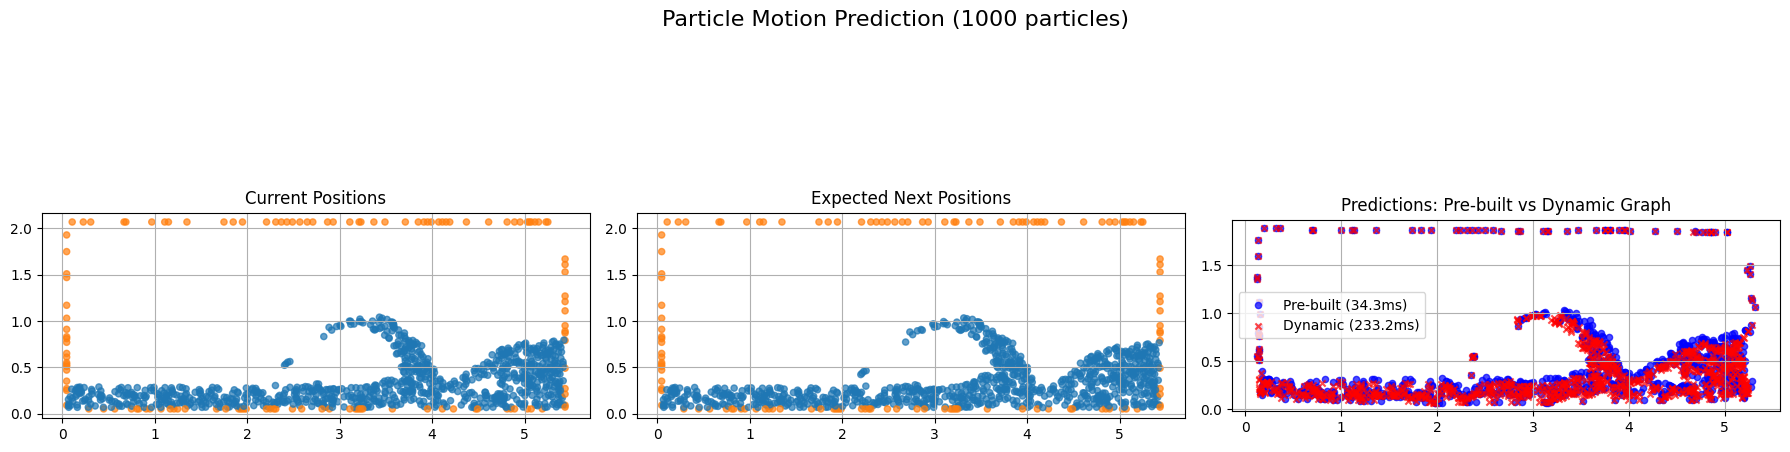

Time with pre-built graph: 34.27ms
Time with dynamic graph building: 233.21ms
Graph building overhead: 198.94ms (580.5%)
Pre-built graph prediction MSE: 0.009008
Dynamic graph prediction MSE: 0.007244
Difference between predictions MSE: 0.001318


In [36]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import time

def visualize_particle_predictions(model, test_data_list, device, particle_count=1000):
    """
    Visualize current, expected, and predicted positions in separate plots
    
    Args:
        model: Trained GNN model
        test_data_list: List of graph data samples
        device: Device for running inference
        particle_count: Number of particles to include in visualization
    """
    # Use the first sample as our baseline
    original_data = test_data_list[50].clone()
    original_num_nodes = original_data.x.shape[0]
    
    print(f"\n--- Visualizing prediction for {particle_count:,} particles ---")
    
    # Subsample if needed
    if particle_count < original_num_nodes:
        # Random sample of particles
        indices = torch.randperm(original_num_nodes)[:particle_count]
        
        # Create node mapping for edges
        node_mapping = -torch.ones(original_num_nodes, dtype=torch.long)
        node_mapping[indices] = torch.arange(particle_count)
        
        # Create subsampled data
        subsampled_x = original_data.x[indices]
        subsampled_y = original_data.y[indices] if original_data.y is not None else None
        
        # Filter edges
        edge_index = original_data.edge_index
        src, dst = edge_index[0], edge_index[1]
        edge_mask = (node_mapping[src] >= 0) & (node_mapping[dst] >= 0)
        subsampled_edges = edge_index[:, edge_mask]
        subsampled_edges[0] = node_mapping[subsampled_edges[0]]
        subsampled_edges[1] = node_mapping[subsampled_edges[1]]
    else:
        # Use all particles
        subsampled_x = original_data.x
        subsampled_edges = original_data.edge_index
        subsampled_y = original_data.y
        indices = torch.arange(original_num_nodes)
    
    # Move data to device
    positions = subsampled_x[:, :2].to(device)
    features = subsampled_x.to(device)
    prebuilt_edges = subsampled_edges.to(device)
    expected_next_pos = subsampled_y.to(device) if subsampled_y is not None else None
    
    model.eval()
    with torch.no_grad():
        # 1. Pre-built graph inference
        prebuilt_time = time.perf_counter()
        predicted_pos_prebuilt = model(features, prebuilt_edges)
        prebuilt_time = (time.perf_counter() - prebuilt_time) * 1000  # ms
        
        # 2. Graph building at inference time with spatial partitioning
        build_time = time.perf_counter()
        
        # Use the spatial partitioning function for efficient graph building
        # Extract just the positions for graph building
        positions_cpu = positions.cpu()  # Move to CPU for graph building
        
        # Build graph with spatial partitioning
        built_edge_index = build_neighbor_graph(
            positions_cpu, 
            radius=0.1,
            max_neighbors=20
        )
        
        # Move back to device for inference
        built_edge_index = built_edge_index.to(device)
        
        # Run inference with newly built graph
        predicted_pos_built = model(features, built_edge_index)
        build_time = (time.perf_counter() - build_time) * 1000  # ms
    
    # Move results to CPU for plotting
    current_pos = positions.cpu().numpy()
    pred_pos_prebuilt = predicted_pos_prebuilt.cpu().numpy()
    pred_pos_built = predicted_pos_built.cpu().numpy()
    expected_pos = expected_next_pos.cpu().numpy() if expected_next_pos is not None else None
    
    # Define colors for different types of particles
    if subsampled_x.shape[1] > 3:  # Check if we have type information
        particle_type_features = subsampled_x[:, 2:-1].cpu()  # Extract type features
        particle_types = torch.argmax(particle_type_features, dim=1).numpy()
        # Map particle types to colors
        colormap = plt.cm.tab10
        colors = colormap(particle_types % 10)
    else:
        colors = 'blue'  # Default color
    
    # Create visualization - 3 separate plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Particle Motion Prediction ({particle_count} particles)", fontsize=16)
    
    # Plot 1: Current positions
    ax1 = axes[0]
    ax1.set_title(f"Current Positions")
    ax1.scatter(current_pos[:, 0], current_pos[:, 1], s=20, c=colors, alpha=0.7)
    ax1.set_aspect('equal')
    ax1.grid(True)
    
    # Plot 2: Expected next positions
    ax2 = axes[1]
    ax2.set_title(f"Expected Next Positions")
    if expected_pos is not None:
        ax2.scatter(expected_pos[:, 0], expected_pos[:, 1], s=20, c=colors, alpha=0.7)
    else:
        ax2.text(0.5, 0.5, 'No expected positions available', 
                 ha='center', va='center', transform=ax2.transAxes)
    ax2.set_aspect('equal')
    ax2.grid(True)
    
    # Plot 3: Predictions comparison
    ax3 = axes[2]
    ax3.set_title(f"Predictions: Pre-built vs Dynamic Graph")
    ax3.scatter(pred_pos_prebuilt[:, 0], pred_pos_prebuilt[:, 1], s=20, 
               marker='o', c='blue', alpha=0.7, label=f'Pre-built ({prebuilt_time:.1f}ms)')
    ax3.scatter(pred_pos_built[:, 0], pred_pos_built[:, 1], s=20, 
               marker='x', c='red', alpha=0.7, label=f'Dynamic ({build_time:.1f}ms)')
    ax3.legend()
    ax3.set_aspect('equal')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate prediction differences
    prebuilt_vs_expected_mse = ((pred_pos_prebuilt - expected_pos) ** 2).mean() if expected_pos is not None else None
    dynamic_vs_expected_mse = ((pred_pos_built - expected_pos) ** 2).mean() if expected_pos is not None else None
    prebuilt_vs_dynamic_mse = ((pred_pos_prebuilt - pred_pos_built) ** 2).mean()
    
    print(f"Time with pre-built graph: {prebuilt_time:.2f}ms")
    print(f"Time with dynamic graph building: {build_time:.2f}ms")
    print(f"Graph building overhead: {build_time - prebuilt_time:.2f}ms ({(build_time/prebuilt_time - 1)*100:.1f}%)")
    
    if expected_pos is not None:
        print(f"Pre-built graph prediction MSE: {prebuilt_vs_expected_mse:.6f}")
        print(f"Dynamic graph prediction MSE: {dynamic_vs_expected_mse:.6f}")
    
    print(f"Difference between predictions MSE: {prebuilt_vs_dynamic_mse:.6f}")
    
    return {
        'current_pos': current_pos,
        'expected_pos': expected_pos,
        'prebuilt_pred': pred_pos_prebuilt,
        'dynamic_pred': pred_pos_built,
        'prebuilt_time_ms': prebuilt_time,
        'dynamic_time_ms': build_time,
    }

# Run the visualization for 1000 particles
result = visualize_particle_predictions(model, test_data_list, device, particle_count=1000)

In [1]:
def visualize_single_prediction(model, test_loader, device, sample_idx=None):
    """Visualize a single prediction showing current, true next, and predicted next states"""
    
    model.eval()
    
    # Get all test data first
    all_batches = []
    for batch in test_loader:
        all_batches.append(batch)
    
    # Select random sample if not specified
    if sample_idx is None:
        # sample_idx = torch.randint(0, len(all_batches), (1,)).item()
        sample_idx = 1;
    # Get the selected batch
    sample_batch = all_batches[sample_idx].to(device)
    
    with torch.no_grad():
        # Make prediction
        pred_positions = model(sample_batch.x, sample_batch.edge_index, sample_batch.batch)
    
    # Extract data
    current_positions = sample_batch.x[:, :2].cpu()  # Current positions (x, y)
    true_next_positions = sample_batch.y.cpu()       # True next positions
    pred_next_positions = pred_positions.cpu()       # Predicted next positions
    particle_types = sample_batch.x[:, 2:-1].cpu()   # Particle type features
    
    # Get particle type for coloring (assuming first one-hot dimension indicates fluid vs boundary)
    if particle_types.shape[1] > 1:
        particle_colors = particle_types[:, 0]  # Use first type indicator
    else:
        particle_colors = torch.zeros(len(current_positions))
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot current state
    ax1 = axes[0]
    scatter1 = ax1.scatter(current_positions[:, 0], current_positions[:, 1], 
                          c=particle_colors, s=20, alpha=0.7, 
                          cmap='viridis', edgecolor='black', linewidth=0.5)
    ax1.set_title('Current State', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Plot true next state
    ax2 = axes[1]
    scatter2 = ax2.scatter(true_next_positions[:, 0], true_next_positions[:, 1], 
                          c=particle_colors, s=20, alpha=0.7, 
                          cmap='viridis', edgecolor='black', linewidth=0.5)
    ax2.set_title('True Next State', fontsize=14, fontweight='bold')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')
    
    # Plot predicted next state
    ax3 = axes[2]
    scatter3 = ax3.scatter(pred_next_positions[:, 0], pred_next_positions[:, 1], 
                          c=particle_colors, s=20, alpha=0.7, 
                          cmap='viridis', edgecolor='black', linewidth=0.5)
    ax3.set_title('Predicted Next State', fontsize=14, fontweight='bold')
    ax3.set_xlabel('X Position')
    ax3.set_ylabel('Y Position')
    ax3.grid(True, alpha=0.3)
    ax3.axis('equal')
    
    # Add colorbar for particle types
    cbar = plt.colorbar(scatter1, ax=axes, orientation='horizontal', 
                       pad=0.1, fraction=0.05, aspect=30)
    cbar.set_label('Particle Type', fontsize=12)
    
    # Calculate and display metrics
    error = torch.norm(pred_next_positions - true_next_positions, dim=1)
    mean_error = error.mean().item()
    max_error = error.max().item()
    
    plt.suptitle(f'Sample {sample_idx} - Mean Error: {mean_error:.4f}, Max Error: {max_error:.4f}', 
                fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print(f"\nSample {sample_idx} Statistics:")
    print(f"Number of particles: {len(current_positions)}")
    print(f"Mean prediction error: {mean_error:.6f}")
    print(f"Max prediction error: {max_error:.6f}")
    print(f"Standard deviation of error: {error.std().item():.6f}")
    print(f"Position range - X: [{current_positions[:, 0].min():.3f}, {current_positions[:, 0].max():.3f}]")
    print(f"Position range - Y: [{current_positions[:, 1].min():.3f}, {current_positions[:, 1].max():.3f}]")
    
    return {
        'sample_idx': sample_idx,
        'current_positions': current_positions,
        'true_next_positions': true_next_positions,
        'pred_next_positions': pred_next_positions,
        'errors': error,
        'mean_error': mean_error,
        'max_error': max_error
    }

def visualize_movement_vectors(model, test_loader, device, sample_idx=None, max_particles=200):
    """Visualize particle movements with velocity vectors"""
    
    model.eval()
    
    # Get all test data first
    all_batches = []
    for batch in test_loader:
        all_batches.append(batch)
    
    # Select random sample if not specified
    if sample_idx is None:
        sample_idx = torch.randint(0, len(all_batches), (1,)).item()
    
    sample_batch = all_batches[sample_idx].to(device)
    
    with torch.no_grad():
        pred_positions = model(sample_batch.x, sample_batch.edge_index, sample_batch.batch)
    
    # Extract data
    current_positions = sample_batch.x[:, :2].cpu()
    true_next_positions = sample_batch.y.cpu()
    pred_next_positions = pred_positions.cpu()
    
    # Subsample particles if too many for clear visualization
    if len(current_positions) > max_particles:
        indices = torch.randperm(len(current_positions))[:max_particles]
        current_positions = current_positions[indices]
        true_next_positions = true_next_positions[indices]
        pred_next_positions = pred_next_positions[indices]
    
    # Calculate movement vectors
    true_movement = true_next_positions - current_positions
    pred_movement = pred_next_positions - current_positions
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # True movements
    ax1 = axes[0]
    ax1.scatter(current_positions[:, 0], current_positions[:, 1], 
               c='lightblue', s=30, alpha=0.7, edgecolor='black', 
               label='Current Position')
    ax1.quiver(current_positions[:, 0], current_positions[:, 1],
              true_movement[:, 0], true_movement[:, 1],
              color='red', alpha=0.8, scale_units='xy', scale=1,
              width=0.003, label='True Movement')
    ax1.set_title('True Particle Movements', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Predicted movements
    ax2 = axes[1]
    ax2.scatter(current_positions[:, 0], current_positions[:, 1], 
               c='lightblue', s=30, alpha=0.7, edgecolor='black',
               label='Current Position')
    ax2.quiver(current_positions[:, 0], current_positions[:, 1],
              pred_movement[:, 0], pred_movement[:, 1],
              color='green', alpha=0.8, scale_units='xy', scale=1,
              width=0.003, label='Predicted Movement')
    ax2.set_title('Predicted Particle Movements', fontsize=14, fontweight='bold')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')
    
    # Calculate movement statistics
    true_movement_magnitude = torch.norm(true_movement, dim=1)
    pred_movement_magnitude = torch.norm(pred_movement, dim=1)
    movement_error = torch.norm(pred_movement - true_movement, dim=1)
    
    plt.suptitle(f'Sample {sample_idx} - Movement Visualization\n'
                f'Avg True Movement: {true_movement_magnitude.mean():.4f}, '
                f'Avg Pred Movement: {pred_movement_magnitude.mean():.4f}, '
                f'Avg Movement Error: {movement_error.mean():.4f}', 
                fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'sample_idx': sample_idx,
        'true_movement': true_movement,
        'pred_movement': pred_movement,
        'movement_error': movement_error
    }

# Visualize random samples
print("Visualizing random prediction samples...")

# Show 3 random samples
for i in range(3):
    print(f"\n{'='*50}")
    print(f"VISUALIZATION {i+1}")
    print('='*50)
    
    # Single state visualization
    result = visualize_single_prediction(model, test_loader, device)
    
    # Movement vectors visualization
    visualize_movement_vectors(model, test_loader, device, 
                              sample_idx=result['sample_idx'], 
                              max_particles=150)

print("\n" + "="*60)
print("PREDICTION VISUALIZATION COMPLETE")
print("="*60)
print("Generated visualizations showing:")
print("1. Current state, true next state, and predicted next state")
print("2. Particle movement vectors (true vs predicted)")
print("3. Error statistics and particle distributions")
print("4. Color-coded particle types for better understanding")

Visualizing random prediction samples...

VISUALIZATION 1


NameError: name 'model' is not defined